# Imports

In [23]:
import gym
from gym.envs.robotics import utils
import numpy as np
import os
from stable_baselines3 import  SAC, DDPG, TD3
import stable_baselines3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.her import   HerReplayBuffer
# from stable_baselines3.td3.policies import MultiInputPolicy
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from fetch_image_env import FetchReachImageEnv
import torch as th
from torch import nn
import utils
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import  SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise

from stable_baselines3.her import   HerReplayBuffer
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from fetch_image_env import FetchReachImageEnv, make_sb3_env, make
import gym
from tqdm import tqdm
  
from stable_baselines3.common.env_checker import check_env
from gym.wrappers import Monitor,TimeLimit
from video import VideoRecorder
from base import GoalEnv


# PointMass Env 

In [49]:
import os
import numpy as np
import gym
import tempfile
import xml.etree.ElementTree as ET
from base import GoalEnv

class Reach(GoalEnv):
    TARGET_SIZE = None
    ARENA_SPACE_LOW = None
    ARENA_SPACE_HIGH = None
    TARGET_DIM = None # The current location in ref to target is skill_obs[:TARGET_DIM] = obs[AGENT_DIM:AGENT_DIM+SKILL_DIM][:TARGET_DIM]
    REWARD_SCALE = None
    SPARSE_REWARD = None
    SURVIVE_REWARD = 0
    VISUALIZE = False

    def __init__(self,initial_qpos,  seed=None,model_path=None):
        self.target = self.ARENA_SPACE_HIGH # Init to far away from agent start.
        self.num_reached = 0
        if model_path is None:
            model_path = self.ASSET
#         xml_path = os.path.join("./assets", self.ASSET)
        
        self.init_site=None
        super(Reach, self).__init__(initial_qpos=initial_qpos, model_path=model_path)

    def get_obs(self):
        pass

    def compute_reward(self, achieved_goal, desired_goal, info):
        dist_to_target = np.linalg.norm(achieved_goal - desired_goal)
        reward = -1*self.REWARD_SCALE * dist_to_target
        if dist_to_target < self.TARGET_SIZE:
            reward += self.SPARSE_REWARD
        reward += self.SURVIVE_REWARD
        return reward
    

    def step(self, action):
        self.do_simulation(action, self.frame_skip)
        obs = self.get_obs()
        desired_goal = self.target
        achieved_goal = obs['achieved_goal']
        reward = self.compute_reward(achieved_goal, desired_goal, None)
        done = False
        if np.linalg.norm(achieved_goal - desired_goal) < self.TARGET_SIZE:
            done = True
        return obs, reward, done, {'success' : done}
        
class ReachNav(Reach):
    def __init__(self, initial_qpos,seed):
        self.SKILL_DIM = 2
        self.TARGET_DIM = 2
        self.TASK_DIM = 4 # agent position, target position
        self.TARGET_SIZE = 0.6
        self.REWARD_SCALE = 0.1
        self.SPARSE_REWARD = 50
        self.VISUALIZE = True
        self.target_range=5
        
        super(ReachNav, self).__init__(initial_qpos,seed)

class Reach_PointMass(ReachNav):
    
    
    def __init__(self, initial_qpos,seed=10 ,fixed=False):
        self.ASSET = 'point_mass.xml'
        self.AGENT_DOF = 2
        self.FRAME_SKIP = 3
        self.fixed=fixed
        
        super(Reach_PointMass, self).__init__(initial_qpos,seed)
        self.init_site = self.sim.model.site_pos[0].copy()
        
        
   
    def viewer_setup(self):
        self.viewer.cam.distance = 14
        self.viewer.cam.azimuth = 90.
        self.viewer.cam.elevation = -90.0
        self.viewer.cam.lookat[0] = -0.05821135
        self.viewer.cam.lookat[1] = 0.
        self.viewer.cam.lookat[2] = 0.5
        #pass
    def get_image(self, width=400, height=400):
        # move the target outside the camera frame 
        site_id = self.sim.model.site_name2id('target0')
        if self.init_site is not None :
            
            self.sim.model.site_pos[site_id] =  self.init_site 
            self.sim.forward()
        self._get_viewer("rgb_array").render(width,height)
        data = self._get_viewer("rgb_array").read_pixels(width, height, depth=False)
        assert data is not None,"sim.render is None"
        return data[::-1,:,:]
    

    
    def get_goal_image(self):
        desired_goal= self.target
        # grip_pos = self.sim.data.get_site_xpos('robot0:grip') # current gripper state
        # move point_mass to target , take image and move back
        
        qpos = self.sim.get_state().qpos
        qvel = self.sim.get_state().qvel
       
        self.set_state(self.target, qvel)
        self.sim.forward()
#         for _ in range(10):
#             self.sim.step()
        
        # self._render_callback() = None
        
        
        goal_image =  self.get_image() 
        
        self.set_state(qpos, qvel)
        self.sim.forward()
#         for _ in range(10):
#             self.sim.step()
        return goal_image.copy()
    
    def get_obs(self):
        return {
            'observation' : np.concatenate((self.sim.data.qvel.flat[:],
                                            self.get_body_com("torso")[:2]), axis=0),
            
            'achieved_goal' : self.get_body_com("torso")[:2],
            'desired_goal' : self.target,
            'image_observation': self.get_image(),
            'desire_goal_image': self.get_goal_image()
            
            
        }
        
    
    def render_callback(self):
        sites_offset = (self.sim.data.site_xpos - self.sim.model.site_pos).copy()
        site_id = self.sim.model.site_name2id('target0')
        self.sim.model.site_pos[site_id][:2]= self.target - sites_offset[0][:2]
        self.sim.forward()
        pass


    
        ## bring the site to the target location 
    def reset(self):
        # randomize target
       
        
        qpos = self.init_qpos + self.np_random.uniform(low=-self.TARGET_SIZE, high=self.TARGET_SIZE, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.uniform(low=-0.2, high=0.4, size=self.model.nv)
        self.set_state(qpos, qvel)
        
        
        if not self.fixed:
            
            self.target=  self.np_random.uniform(low=-self.target_range, high=self.target_range, size=2)
            self.target += self.sim.data.qpos.ravel().copy()
        return self.get_obs()

    
    def _env_setup(self, initial_qpos):
        for name, value in initial_qpos.items():
            self.sim.data.set_joint_qpos(name, value)
#         utils.reset_mocap_welds(self.sim)
        # calling forward rewrite the values in self.data 
        self.sim.forward()
#         self.initial_pos = self.init_qpos + self.np_random.uniform(low=-0.2, high=0.2, size=self.AGENT_DOF)
        self.target= self.np_random.uniform(low=-self.target_range, high=self.target_range, size=2)


## Initialize Env 

In [45]:
initial_qpos = {
            'ballx': 0,
            'bally': 0
            
        }
point_env = Reach_PointMass(initial_qpos,seed=0)
point_env = TimeLimit(point_env,max_episode_steps=100)

In [18]:
r= point_env.reset()

100


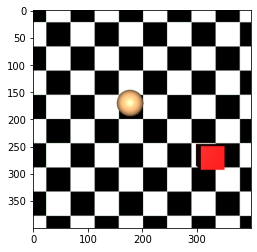

In [31]:
display_obs(point_env)

In [52]:
initial_qpos = {
            'ballx': 0,
            'bally': 0
            
        }
env = Reach_PointMass(initial_qpos,seed=1)
env = TimeLimit(point_env,max_episode_steps=100)
count = 0
obs = env.reset()
from video import VideoRecorder

v = VideoRecorder(video_dir="./video")
v.init(enabled=True)
episode_reward = 0 
for i in range(300):
#     action, _states = model.predict(obs)
    obs, reward, done, info = env.step(env.action_space.sample())
    episode_reward+=reward
    # env.render(mode="human")
    v.record(env)
    count+=1
    if done:
        print(count)
        count=0
        episode_reward= 0 
        obs = env.reset()
v.save("7.mp4")

100
100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


100


# Visualization functions

In [179]:
def display_image(obs):
    from IPython import display
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    img = plt.imshow(obs)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [26]:
def display_obs(env):
    from IPython import display
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
#     env = gym.make('FetchReach-v1')
    count=0
    obs = env.reset()
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    for _ in range(100):
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        count+=1
        if done:
            print(count)
            count=0
            obs = env.reset()

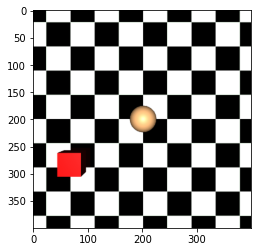

In [144]:
display_image(point_env.render("rgb_array"))

In [145]:
move_point_mass_qpos()

NameError: name 'move_point_mass_qpos' is not defined

# Debugging Functions

In [6]:
def print_states(point_env):

    print(point_env.data.get_body_xpos("torso"), "torso get_body_xpos")


    print(point_env.get_body_com("torso"),"torso get_body_com")

    print(point_env.init_qpos, "--- init_qpos")

    print(point_env.sim.get_state(), "---get_state()")

    print(point_env.model.body_names,"--body_names")

    print(point_env.data.get_site_xpos("target0") ,"--data.get_site_xpos")
    print(point_env.get_site_com("target0") , "--get_site_com")
    print(point_env.sim.data.qpos.ravel() , "--qpos.ravel()")
    print(point_env.sim.data.site_xpos,"---site_xpos ")
    print(point_env.model.site_pos[0], "--model.site_pos")
    print(point_env.target, "--target")
    sites_offset = (point_env.sim.data.site_xpos - point_env.sim.model.site_pos).copy()
    print(sites_offset, "offset")
    print(point_env.init_site,"init_site")
    

In [7]:
print_states(point_env)

[0. 0. 0.] torso get_body_xpos
[0. 0. 0.] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([0., 0.]), qvel=array([0., 0.]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[500.  500.    0.6] --data.get_site_xpos
[500.  500.    0.6] --get_site_com
[0. 0.] --qpos.ravel()
[[500.  500.    0.6]] ---site_xpos 
[500.  500.    0.6] --model.site_pos
[-3.74282375 -2.31694542] --target
[[0. 0. 0.]] offset
[500.  500.    0.6] init_site


In [130]:
point_env.sim.get_state().qpos

array([-0.03727648,  0.50439026])

In [222]:
offset = point_env.data.get_site_xpos("target0") - point_env.model.site_pos[0]

In [8]:
def move_point_mass_qpos(point_env, des):
#     sites_offset = (point_env.sim.data.site_xpos - point_env.sim.model.site_pos).copy()
#     site_id = point_env.sim.model.site_name2id('target0')
#     point_env.sim.model.site_pos[site_id][:2]= des - sites_offset[0][:2]
#         self.sim.forward()
    qpos = point_env.sim.get_state().qpos
    qvel = point_env.sim.get_state().qvel
    des= np.array(des)
    point_env.set_state(des, qvel)
#     point_env.model.body_pos[-2][:2]= des
    point_env.sim.forward()
    display_image(point_env.render(mode="rgb_array"))

In [9]:
def move_site(point_env, des):
    sites_offset = (point_env.sim.data.site_xpos - point_env.sim.model.site_pos).copy()
    
    point_env.model.site_pos[0][:2] = des - sites_offset[0][:2]
    point_env.sim.forward()
    display_image(point_env.render(mode="rgb_array"))

In [10]:
def counter(func):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
    # Call the function being decorated and return the result
        return func(*args, **kwargs)
    wrapper.count = 0
  # Return the new decorated function
    return wrapper

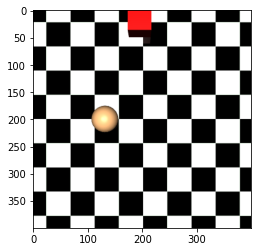

In [227]:
move_point_mass_qpos(point_env, des=[-1,0])

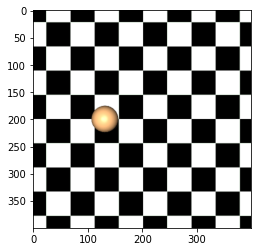

In [231]:
display_image(point_env.get_image())

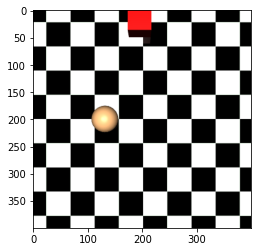

In [232]:
display_image(point_env.render("rgb_array"))

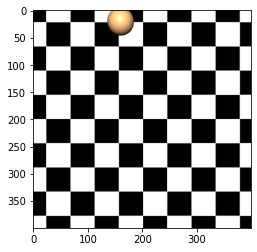

In [230]:
display_image(point_env.get_goal_image())

inside condition
inside condition
100
inside condition
inside condition


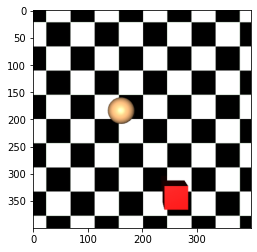

In [233]:
display_obs(point_env)

In [224]:
r= point_env.reset()

inside condition
inside condition


In [198]:
print_states(point_env)

[-0.03727648  0.50439026  0.        ] torso get_body_xpos
[-0.03727648  0.50439026  0.        ] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([-0.03727648,  0.50439026]), qvel=array([ 0.10035727, -0.05663494]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[ 3.51571336 -1.97134681  0.6       ] --data.get_site_xpos
[ 3.51571336 -1.97134681  0.6       ] --get_site_com
[-0.03727648  0.50439026] --qpos.ravel()
[[ 3.51571336 -1.97134681  0.6       ]] ---site_xpos 
[ 3.51571336 -1.97134681  0.6       ] --model.site_pos
[ 1.67530334 -3.98590777] --target
[[0. 0. 0.]] offset
[ 3.51571336 -1.97134681  0.6       ] init_site


In [43]:
 point_env.sim.model.site_pos[0][:2]

array([-4.,  0.])

In [44]:
point_env.target

array([3.4139424 , 4.89900978])

In [85]:
des = point_env.data.site_xpos
des

array([[0. , 0. , 0.6]])

In [86]:
point_env.model.site_pos

array([[0. , 0. , 0.6]])

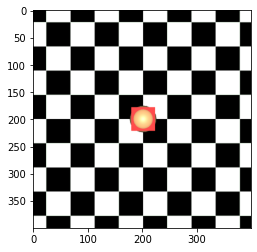

In [87]:

move_site(point_env, [0,0])

In [ ]:
point_env.reset()

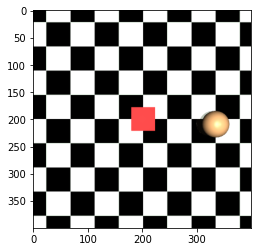

In [114]:
display_image(point_env.render(mode="rgb_array"))

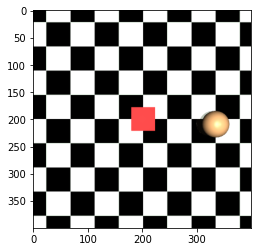

In [113]:
display_image(point_env.get_goal_image())

### get_goal_image doesn't work .It returns the current observation 

In [115]:
print_states(point_env)

[ 3.79440048 -0.27072109  0.        ] torso get_body_xpos
[ 3.79440048 -0.27072109  0.        ] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([0.06637964, 0.27150674]), qvel=array([ 0.02466863, -0.38011232]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[0.  0.  0.6] --get_site_xpos
[0.  0.  0.6] --get_site_com
[0.06637964 0.27150674] --qpos.ravel()
[0.  0.  0.6] --model.site_pos
[ 3.72802084 -0.54222783] --target
[[0. 0. 0.]] offset


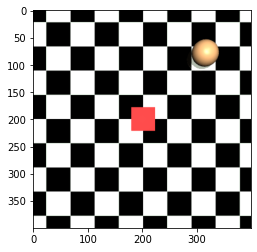

In [116]:
move_point_mass(point_env,des=[3.72802084 -0.54222783] )

### reset 2 



In [ ]:
point_env.reset()

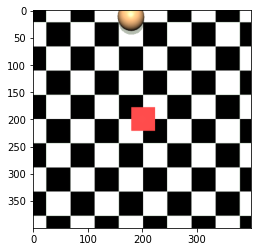

In [120]:
display_image(point_env.render(mode="rgb_array"))

### checking if coordinate system has changed

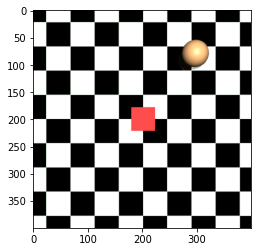

In [122]:
move_point_mass(point_env, des=[3.72802084 -0.54222783] )

### reset 3

In [123]:

k= point_env.reset()

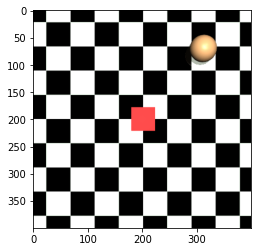

In [124]:
move_point_mass(point_env, des=[3.72802084 -0.54222783])

## so yes at every reset the coordinate system is changing 

# Check with move_point_mass_qpos

## before reset

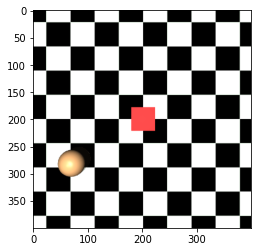

In [152]:

display_image(point_env.render(mode="rgb_array"))

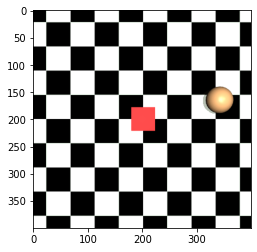

In [143]:
move_point_mass_qpos(point_env, des=np.array([4,1]))

In [153]:
print_states(point_env)

[-3.74282375 -2.31694542  0.        ] torso get_body_xpos
[-3.74282375 -2.31694542  0.        ] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([-3.74282375, -2.31694542]), qvel=array([0., 0.]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[0.  0.  0.6] --get_site_xpos
[0.  0.  0.6] --get_site_com
[-3.74282375 -2.31694542] --qpos.ravel()
[0.  0.  0.6] --model.site_pos
[-3.74282375 -2.31694542] --target
[[0. 0. 0.]] offset


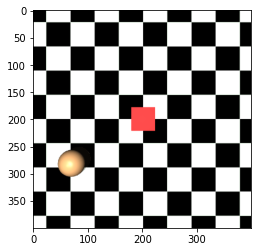

In [147]:
move_point_mass_qpos(point_env, des=point_env.target)

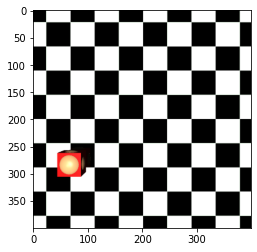

In [148]:
move_site(point_env,des=point_env.target)

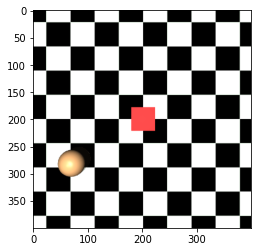

In [149]:
move_site(point_env,des = np.array([0,0]))

In [127]:
r= point_env.reset()

In [128]:
print_states(point_env)

[0.17828516 0.35526599 0.        ] torso get_body_xpos
[0.17828516 0.35526599 0.        ] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([0.17828516, 0.35526599]), qvel=array([-0.20298445,  0.18165684]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[50.   0.   0.6] --data.get_site_xpos
[50.   0.   0.6] --get_site_com
[0.17828516 0.35526599] --qpos.ravel()
[[50.   0.   0.6]] ---site_xpos 
[50.   0.   0.6] --model.site_pos
[ 3.51571336 -1.97134681] --target
[[0. 0. 0.]] offset
[50.   0.   0.6] init_site


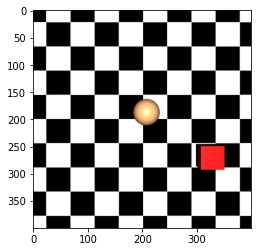

In [129]:
display_image(point_env.render(mode="rgb_array"))

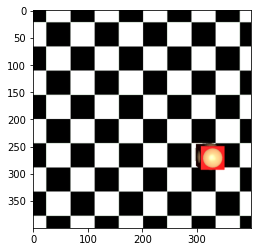

In [130]:
display_image(point_env.get_goal_image())

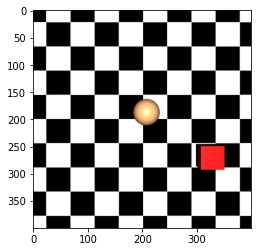

In [132]:
display_image(point_env.get_image())

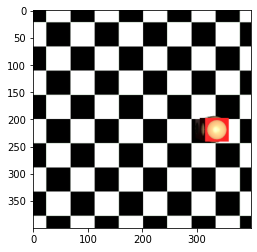

In [164]:
move_site(point_env, des=point_env.target)

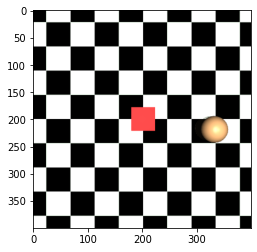

In [163]:
move_point_mass_qpos(point_env, des=point_env.target)

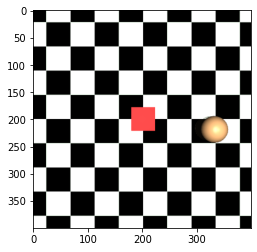

In [161]:


move_site(point_env, des=[0,0])


In [167]:
print_states(point_env)

[ 3.72802084 -0.54222783  0.        ] torso get_body_xpos
[ 3.72802084 -0.54222783  0.        ] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([ 3.72802084, -0.54222783]), qvel=array([ 0.02466863, -0.38011232]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[ 3.72802084 -0.54222783  0.6       ] --data.get_site_xpos
[ 3.72802084 -0.54222783  0.6       ] --get_site_com
[ 3.72802084 -0.54222783] --qpos.ravel()
[ 3.72802084 -0.54222783  0.6       ] --model.site_pos
[ 3.72802084 -0.54222783] --target
[[0. 0. 0.]] offset


# modified env to understand offset 

In [103]:
import os
import numpy as np
import gym
import tempfile
import xml.etree.ElementTree as ET
from base import GoalEnv

class Reach(GoalEnv):
    TARGET_SIZE = None
    ARENA_SPACE_LOW = None
    ARENA_SPACE_HIGH = None
    TARGET_DIM = None # The current location in ref to target is skill_obs[:TARGET_DIM] = obs[AGENT_DIM:AGENT_DIM+SKILL_DIM][:TARGET_DIM]
    REWARD_SCALE = None
    SPARSE_REWARD = None
    SURVIVE_REWARD = 0
    VISUALIZE = False

    def __init__(self,initial_qpos, model_path=None):
        self.target = self.ARENA_SPACE_HIGH # Init to far away from agent start.
        self.num_reached = 0
        if model_path is None:
            model_path = self.ASSET
#         xml_path = os.path.join("./assets", self.ASSET)
        
        
        super(Reach, self).__init__(initial_qpos=initial_qpos, model_path=model_path)

    def get_obs(self):
        pass

    def compute_reward(self, achieved_goal, desired_goal, info):
        dist_to_target = np.linalg.norm(achieved_goal - desired_goal)
        reward = -1*self.REWARD_SCALE * dist_to_target
        if dist_to_target < self.TARGET_SIZE:
            reward += self.SPARSE_REWARD
        reward += self.SURVIVE_REWARD
        return reward
    

    def step(self, action):
        self.do_simulation(action, self.frame_skip)
        obs = self.get_obs()
        desired_goal = self.target
        achieved_goal = self.skill_obs(obs)[:self.TARGET_DIM]
        reward = self.compute_reward(achieved_goal, desired_goal, None)
        done = False
        if np.linalg.norm(achieved_goal - desired_goal) < self.TARGET_SIZE:
            done = True
        return obs, reward, done, {'success' : done}
        
class ReachNav(Reach):
    def __init__(self, initial_qpos):
        self.ARENA_SPACE_LOW = np.array([-6.0, -6.0])
        self.ARENA_SPACE_HIGH = np.array([6.0, 6.0])
        self.SKILL_DIM = 2
        self.TARGET_DIM = 2
        self.TASK_DIM = 4 # agent position, target position
        self.TARGET_SIZE = 0.9
        self.REWARD_SCALE = 0.1
        self.SPARSE_REWARD = 50
        self.VISUALIZE = True
        self.target_range=6
        
        super(ReachNav, self).__init__(initial_qpos)

class Reach_PointMass(ReachNav):
    
    
    def __init__(self, initial_qpos):
        self.ASSET = 'point_mass.xml'
        self.AGENT_DIM = 2
        self.FRAME_SKIP = 3
        super(Reach_PointMass, self).__init__(initial_qpos)

   
    def viewer_setup(self):
        self.viewer.cam.distance = 14
        self.viewer.cam.azimuth = 90.
        self.viewer.cam.elevation = -90.0
        self.viewer.cam.lookat[0] = -0.05821135
        self.viewer.cam.lookat[1] = 0.
        self.viewer.cam.lookat[2] = 0.5
        #pass
    @counter
    def get_image(self, width=400, height=400):
        # move the target outside the camera frame 
#         target_position = self.model.body_pos[-2][:self.TARGET_DIM].copy()
#           target_position = 
#         self.model.body_pos[-2][:self.TARGET_DIM] = [100.0,100.0]
        site_id = self.sim.model.site_name2id('target0')
        print(self.sim.data.site_xpos[0], "inside get_image before shift")
        print(self.sim.model.site_pos[site_id] ," model.site_pos inside get_image before shift")
        
        self.sim.model.site_pos[site_id] =  self.sim.data.site_xpos[0]
        
        self.sim.forward()
        print(self.sim.data.site_xpos[0], "data.site_xpos inside get_image after shift")
        
        print(self.sim.model.site_pos[site_id], " model.site_pos inside get_image after shift")
        
        self._get_viewer("rgb_array").render(width,height)
        data = self._get_viewer("rgb_array").read_pixels(width, height, depth=False)
        assert data is not None,"sim.render is None"
        return data[::-1,:,:]
#         self.sim.forward()
       
#         self.model.body_pos[-2][:self.TARGET_DIM] = target_position
        
     
        return image
    @counter
    def get_goal_image(self):
        desired_goal= self.target
        # move gripper to goal , take image and reset()
        # grip_pos = self.sim.data.get_site_xpos('robot0:grip') # current gripper state
        current_torso =  self.model.body_pos[-1][:self.TARGET_DIM].copy()
        print(self.data.site_xpos[0],"data.site_xpos before")
        print(self.model.site_pos[0], "model.site_pos before ")
        self.model.body_pos[-1][:self.TARGET_DIM] = self.target # moving torso to target position 
#         for _ in range(10):
#             self.sim.step()
        
        # self._render_callback() = None
       
        
        goal_image =  self.get_image() 
        print(self.data.site_xpos[0],"data.site_xpos after")
        print(self.model.site_pos[0], "model.site_pos after")
       

        self.model.body_pos[-1][:self.TARGET_DIM] = current_torso
        
        print(self.data.site_xpos[0],"data.site_xpos next before")
        print(self.model.site_pos[0], "model.site_pos next before")
#         for _ in range(10):
#             self.sim.step()
        return goal_image.copy()



#         desired_goal= self.target
        
#         qpos = self.sim.get_state().qpos
#         qvel = self.sim.get_state().qvel
       
#         self.set_state(self.target, qvel)
#         self.sim.forward()
        
#         goal_image =  self.get_image() 
        
#         self.set_state(qpos, qvel)
#         self.sim.forward()
#         return goal_image.copy()
    

            
    @counter
    def get_obs(self):
        return {
            'observation' : np.concatenate((self.sim.data.qvel.flat[:],
                                            self.get_body_com("torso")[:2]), axis=0),
            
            'achieved_goal' : self.get_body_com("torso")[:2],
            'desired_goal' : self.target,
            'image_observation': self.get_image(),
            'desire_goal_image': self.get_goal_image()
            
            
        }
        
    
    def render_callback(self):
        pass
#         sites_offset = (self.sim.data.site_xpos - self.sim.model.site_pos).copy()
#         site_id = self.sim.model.site_name2id('target0')
#         self.sim.model.site_pos[site_id][:2] = self.target - sites_offset[0][:2]
#         self.sim.forward()

    
        ## bring the site to the target location 
    def reset(self):
        self.target = self.np_random.uniform(low=self.ARENA_SPACE_LOW, high=self.ARENA_SPACE_HIGH)
        
#         if self.VISUALIZE:
#             self.model.body_pos[-2][:self.TARGET_DIM] = self.target
        qpos = self.init_qpos + self.np_random.uniform(low=-self.TARGET_SIZE, high=self.TARGET_SIZE, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.uniform(low=-0.4, high=0.4, size=self.model.nv)
        self.set_state(qpos, qvel)
        return self.get_obs()
    
    
    def _env_setup(self, initial_qpos):
        for name, value in initial_qpos.items():
            self.sim.data.set_joint_qpos(name, value)
#         utils.reset_mocap_welds(self.sim)
        # calling forward rewrite the values in self.data 
        self.sim.forward()

        # Move end effector into position.
#         gripper_target = np.array([-0.498, 0.005, -0.431 + self.gripper_extra_height]) + self.sim.data.get_site_xpos('robot0:grip')
#         gripper_rotation = np.array([1., 0., 1., 0.])
#         self.sim.data.set_mocap_pos('robot0:mocap', gripper_target)
#         self.sim.data.set_mocap_quat('robot0:mocap', gripper_rotation)
#         for _ in range(10):
#             self.sim.step()

#         self.target= self.np_random.uniform(low=-self.target_range, high=self.target_range, size=2)
        
        # random sample goal position around the point mass within the arena 
        

In [104]:
initial_qpos = {
            'ballx': 0,
            'bally': 0
            
        }
point_env = Reach_PointMass(initial_qpos)
# point_env = TimeLimit(point_env,max_episode_steps=100)

[0.  0.  0.6] inside get_image before shift
[0.  0.  0.6]  model.site_pos inside get_image before shift
[0.  0.  0.6] data.site_xpos inside get_image after shift
[0.  0.  0.6]  model.site_pos inside get_image after shift
[0.  0.  0.6] data.site_xpos before
[0.  0.  0.6] model.site_pos before 
[0.  0.  0.6] inside get_image before shift
[0.  0.  0.6]  model.site_pos inside get_image before shift
[6.  6.  0.6] data.site_xpos inside get_image after shift
[0.  0.  0.6]  model.site_pos inside get_image after shift
[6.  6.  0.6] data.site_xpos after
[0.  0.  0.6] model.site_pos after
[6.  6.  0.6] data.site_xpos next before
[0.  0.  0.6] model.site_pos next before


In [65]:
print_states(point_env)

[0. 0. 0.] torso get_body_xpos
[0. 0. 0.] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([0., 0.]), qvel=array([0., 0.]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[-4.4913885  -2.78033451  0.6       ] --data.get_site_xpos
[-4.4913885  -2.78033451  0.6       ] --get_site_com
[0. 0.] --qpos.ravel()
[0.  0.  0.6] --model.site_pos
[-4.4913885  -2.78033451] --target
[[-4.4913885  -2.78033451  0.        ]] offset


In [88]:
print_states(point_env)

[0. 0. 0.] torso get_body_xpos
[0. 0. 0.] torso get_body_com
[0. 0.] --- init_qpos
MjSimState(time=0.0, qpos=array([0., 0.]), qvel=array([0., 0.]), act=None, udd_state={}) ---get_state()
('world', 'torso', 'floor') --body_names
[6.  6.  0.6] --data.get_site_xpos
[6.  6.  0.6] --get_site_com
[0. 0.] --qpos.ravel()
[[6.  6.  0.6]] ---site_xpos 
[0.  0.  0.6] --model.site_pos
[6. 6.] --target
[[6. 6. 0.]] offset


In [61]:
point_env.get_goal_image.count

1

In [62]:
point_env.target

array([6., 6.])

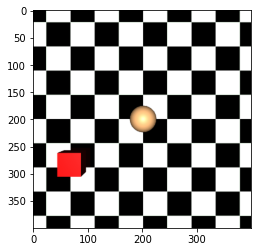

In [134]:
display_image(point_env.render("rgb_array"))

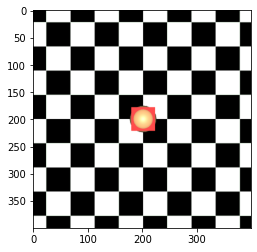

In [31]:
move_site(point_env, des=[0,0])

In [135]:
e= point_env.reset()

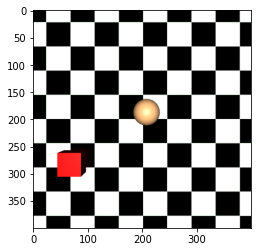

In [136]:
display_image(point_env.get_image())

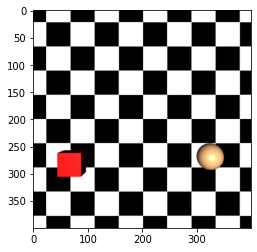

In [137]:
display_image(point_env.get_goal_image())